# Setup and imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display

# Checking for GPU / MPS availability

In [2]:
import os 
import torch

if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
import fastai.torch_core

device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')
    
print(device)

cuda:0


# Load and explore data

In [4]:
# Load data
import hub
ds = hub.load("hub://activeloop/spoken_mnist")

print(ds.info)

print(ds)

ds.summary()

/home/bjorn/miniconda3/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.20) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



\

hub://activeloop/spoken_mnist loaded successfully.

{'citation': 'https://github.com/Jakobovski/free-spoken-digit-dataset', 'description': "# Free Spoken Digit Dataset (FSDD)\n[![DOI](https://zenodo.org/badge/61622039.svg)](https://zenodo.org/badge/latestdoi/61622039)\n\nA simple audio/speech dataset consisting of recordings of spoken digits in `wav` files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.\n\nFSDD is an open dataset, which means it will grow over time as data is contributed.  In order to enable reproducibility and accurate citation the dataset is versioned using Zenodo DOI as well as `git tags`.\n\n### Current status\n- 6 speakers\n- 3,000 recordings (50 of each digit per speaker)\n- English pronunciations\n\n### Organization\nFiles are named in the following format:\n`{digitLabel}_{speakerName}_{index}.wav`\nExample: `7_jackson_32.wav`\n\n### Contributions\nPlease contribute your homemade recordings. All recordings s

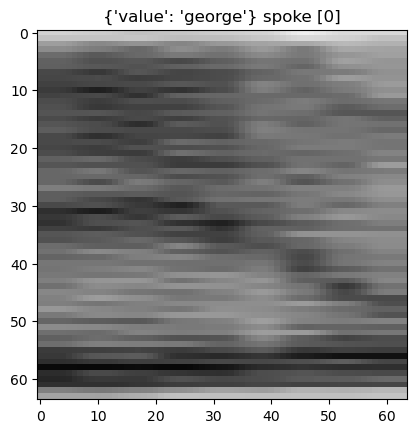

In [5]:

# check out the first spectrogram, it's label, and who spoke it!
import matplotlib.pyplot as plt
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()} spoke {ds.labels[0].numpy()}")
plt.show()

In [6]:
ds.visualize()

HINT: Please forward the port - 42517 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


# Explore the data

In [7]:
labels = ds.labels[0][0].numpy()
print(labels)

0


3000


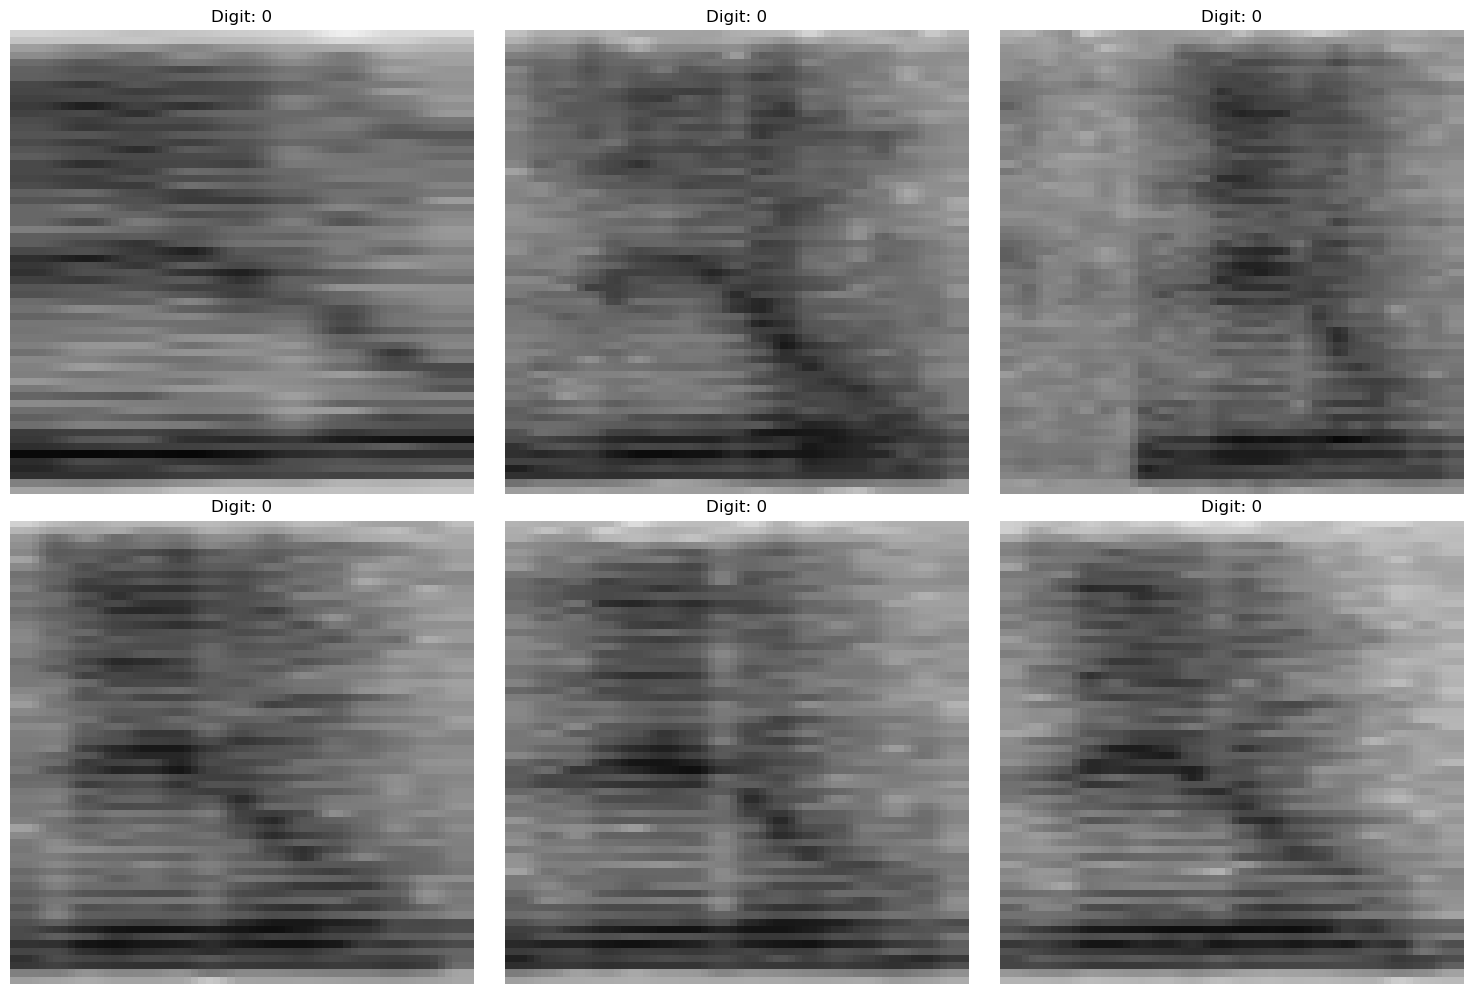

In [8]:
from PIL import Image

spectrograms = ds.spectrograms[0:6].numpy()

print(len(ds.spectrograms))

# Display the 6 images with the lowest face scores
plt.figure(figsize=(15, 10))
for i, img in enumerate(spectrograms):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Digit: {ds.labels[i][0].numpy()}')
    plt.axis('off') 
plt.tight_layout()
plt.show()

/home/bjorn/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bjorn/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


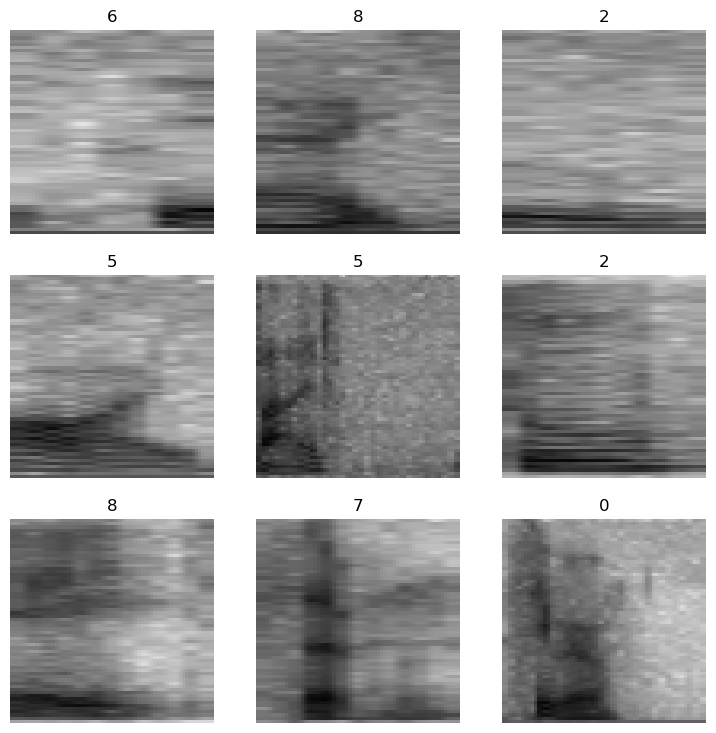

In [9]:
from fastai.vision.all import *

def get_x(r): 
    
    # Avoid mismatched dimensions. Remove 4th channel
    img = r['spectrograms'].numpy()
    rgb = img[:, :, :3]
    return PILImage.create(rgb)
def get_y(r): return r['labels'].numpy()[0]

# Define the DataBlock
spectrogram_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_x=get_x, 
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split data into training and validation sets
)

# Prepare dataloaders
dls = spectrogram_block.dataloaders(ds, bs=64)

# Now you can visualize your data (optional)
dls.show_batch()

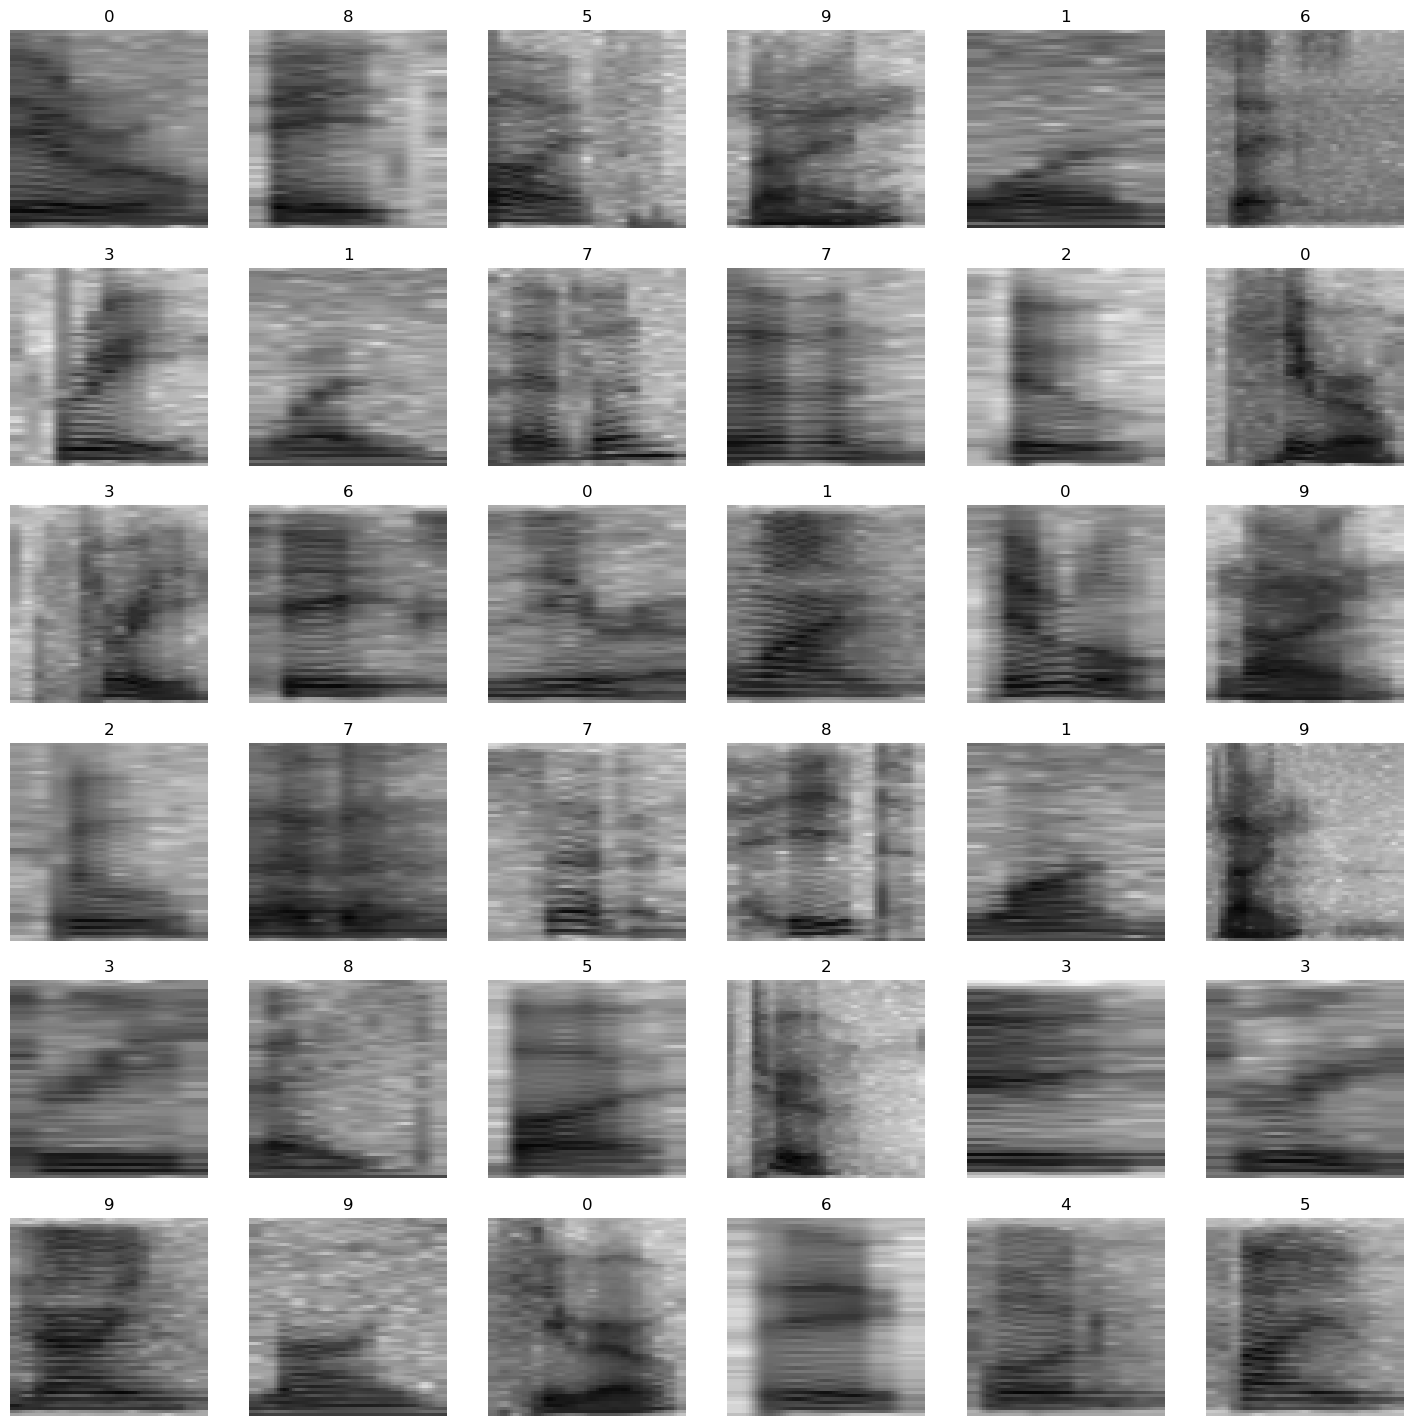

In [10]:
dls.show_batch(nrows=6, ncols=6, max_n=36)

# Train Model

In [11]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.139029,2.453500,0.295000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.955857,1.604216,0.466667,00:06
1,1.341058,1.136066,0.655000,00:06
2,0.823104,0.764900,0.770000,00:06
3,0.474867,0.663533,0.790000,00:05
4,0.262200,0.601619,0.821667,00:06
5,0.148167,0.550595,0.843333,00:06
6,0.087174,0.524565,0.836667,00:06
7,0.051203,0.482162,0.850000,00:06
8,0.036682,0.494314,0.858333,00:06
9,0.025337,0.483973,0.851667,00:06


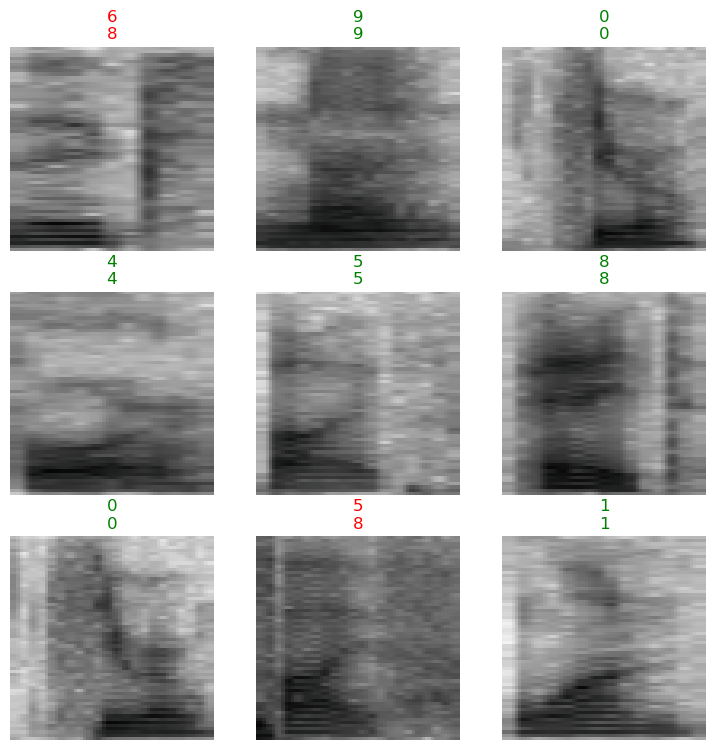

In [12]:
learn.show_results()

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

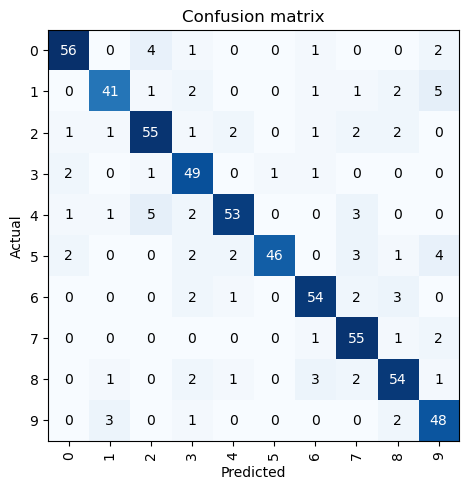

In [14]:
interp.plot_confusion_matrix()

In [15]:
interp.most_confused()

[(1, 9, 5),
 (4, 2, 5),
 (0, 2, 4),
 (5, 9, 4),
 (4, 7, 3),
 (5, 7, 3),
 (6, 8, 3),
 (8, 6, 3),
 (9, 1, 3),
 (0, 9, 2),
 (1, 3, 2),
 (1, 8, 2),
 (2, 4, 2),
 (2, 7, 2),
 (2, 8, 2),
 (3, 0, 2),
 (4, 3, 2),
 (5, 0, 2),
 (5, 3, 2),
 (5, 4, 2),
 (6, 3, 2),
 (6, 7, 2),
 (7, 9, 2),
 (8, 3, 2),
 (8, 7, 2),
 (9, 8, 2),
 (0, 3, 1),
 (0, 6, 1),
 (1, 2, 1),
 (1, 6, 1),
 (1, 7, 1),
 (2, 0, 1),
 (2, 1, 1),
 (2, 3, 1),
 (2, 6, 1),
 (3, 2, 1),
 (3, 5, 1),
 (3, 6, 1),
 (4, 0, 1),
 (4, 1, 1),
 (5, 8, 1),
 (6, 4, 1),
 (7, 6, 1),
 (7, 8, 1),
 (8, 1, 1),
 (8, 4, 1),
 (8, 9, 1),
 (9, 3, 1)]

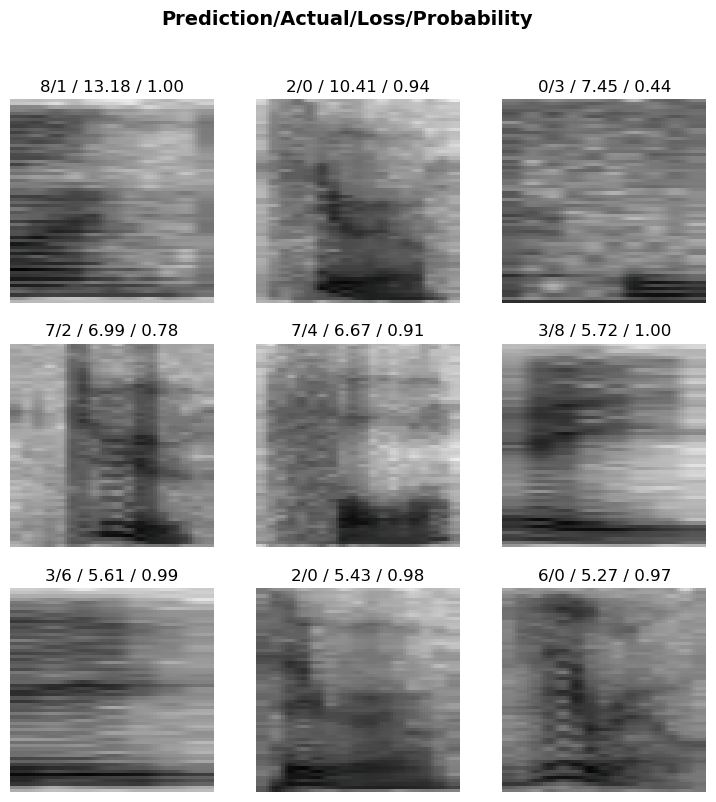

In [16]:
interp.plot_top_losses(9, nrows=3)

# Export model

In [17]:
learn.export('spoken_digit_model.pkl')

# Gradio

In [21]:
from io import BytesIO
import gradio as gr
import scipy.io.wavfile as wav
import soundfile as sf

labels=learn.dls.vocab

# Ref: https://github.com/Jakobovski/free-spoken-digit-dataset/blob/master/utils/spectogramer.py
def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=16, cmap='gray_r'):
    
    sample_rate, samples = wav.read(audio_path)
    
    print("sample rate: ", sample_rate)
    
    # Convert stereo to mono by averaging the two channels if necessary
    if samples.ndim == 2 and samples.shape[1] == 2:
        samples = samples.mean(axis=1)
        
    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
    
    # Save the figure to a bytes buffer
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches="tight", pad_inches=0)
    buf.seek(0)
    img = Image.open(buf)
    
    plt.close(fig)  # Close the figure to free resources

    return img.convert('RGB')

def resample_audio(input, output, target_rate=8000):
    audio, _ = librosa.load(input, sr=target_rate)
    sf.write(output, audio, target_rate)

def predict_digit(audio):
    
    # resample
    resampled_path = "resampled.wav"
    resample_audio(audio, resampled_path)
    
    # Convert the audio to an image
    img = wav_to_spectrogram(resampled_path,"spectrogram.png")
    
    pred,pred_idx,probs = learn.predict(img)
    
    return dict(zip(labels,probs)), img

audio_input = gr.Audio(sources="microphone", type="filepath", interactive=True, format="wav", editable=True, label="Record your audio", max_length=3)
label_output = gr.components.Label()

iface = gr.Interface(fn=predict_digit, inputs=audio_input, outputs=[label_output,"image"])

iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
